In [9]:
import sys
stdout = sys.stdout
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi
from qiskit.visualization import plot_bloch_vector

import warnings
warnings.simplefilter('ignore')

$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
\newcommand{\ketbra}[2]{\left|{#1}\middle\rangle\langle{#2}\right|}
$$

In [10]:
#fix output
sys.stdout = stdout

In [11]:
def assert_correct_counts(counts, expected_value):
    keys = counts.keys()
    if len(keys) == 1 and expected_value == list(keys)[0]:
        print('✅ Correct prediction 🎉')
        return True
    else:
        print('❌ False assertion, maybe there are also more than 1 results! 😥')
        return False

def compile_circuit_and_check(circuit, expected_value, shots=3000):
    simulator = QasmSimulator()
    compiled_circuit = transpile(circuit, simulator)
    job = simulator.run(compiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(circuit)
    result = assert_correct_counts(counts, expected_value)
    return counts, result, list(counts.keys())[0]

def check_if_matrix_is_unitary(qubits, matrix):
    circuit = QuantumCircuit(qubits,qubits)
    try:
        circuit.unitary(addition, range(qubits), label="unitary check")
        print('✅ We got an unitary matrix! 🎉')
    except:
        print('❌ Input matrix is not unitary. 😥')
    

# Full-Adder

The goal is to construct a quantum circuit that resembles a neuron as seen in current machine learning.

<center>
<img src ="https://miro.medium.com/max/875/1*T4ARzySpEQvEnr_9pc78pg.jpeg" />

<em>Image 1: <a href="https://towardsdatascience.com/deep-learning-versus-biological-neurons-floating-point-numbers-spikes-and-neurotransmitters-6eebfa3390e9">Deep Learning Neuron</a></em>
</center>

The neuron consists of 2 components. One is the multiplication of input $x_i$ with weight $w_i$ as well as the summation of all resulting values. To tackle this problem, we will first start with the simpler of the two: _addition_

## Addition in a quantum circuit

Due to the nature of quantum gates, one is not able to simply copy the classical design of a [half-](https://en.wikipedia.org/wiki/Adder_(electronics)#Half_adder) or even [fulladder](https://en.wikipedia.org/wiki/Adder_(electronics)#Full_adder) over to a general quantum computer. This forces us to come up with a new solution that, from the outside, follows the same rules.

### Qubit representation

In quantum circuits, qubits are usually represented as _vectors_, and the qubit states $\ket{0}$ and $\ket{1}$ are represented as $\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ and $\begin{pmatrix} 0 \\ 1 \end{pmatrix}$, respectively. This allows us to test our supposed solutions mathematically before applying them as a circuit.

When the amount of qubits is $n > 1$, we can represent them using a $2^n$ vector which we call _state-vector_. The _state-vector_ shows the current state of _all_ qubits.

$$
S =\ \begin{pmatrix} 0 \\ 1 \\ 0 \\ 0\end{pmatrix} =\ \ket{01}
$$
$$
S =\ \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1\end{pmatrix} =\ \ket{11}
$$
<center>
<em>Example of 2 different state-vectors and their ket representation</em>
</center>

### Gates

Gates in quantum circuits can always be represented as an unitary, reversible matrix. This imposes multiple rules upon us. The matrix $M$ needs to be unitary, which means;

$$
M*M^\dagger =\ M*\overline{M^T} =\ I
$$

This means that our matrix $M$ multiplied with its _conjugate transpose_ $M^\dagger$ results in the identity matrix $I$ of the same size.
The next part is the reversibility of the matrix. In this context, reversibility means we can deduct the input state(s) of the gate from the output state(s). This is also called "bijection" or "one-to-one correspondence".

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/a/a5/Bijection.svg" />

<em>Image 2: <a href="https://en.wikipedia.org/wiki/Bijection">Graphical representation of bijection</a></em>
</center>

Using our _state-vector_, we can now also represent the resulting states with a _state-vector_. Lets assume the following:

<center>
<em>For $n$ qubits, we want to add both together and represent the result in the same qubits</em>
</center>

$$
U_{add} *\ \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0\end{pmatrix} = \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0\end{pmatrix} \\
$$
$$
U_{add} *\ \begin{pmatrix} 0 \\ 1 \\ 0 \\ 0\end{pmatrix} = \begin{pmatrix} 0 \\ 1 \\ 0 \\ 0\end{pmatrix} \\
$$
$$
U_{add} *\ \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0\end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0\end{pmatrix} \\
$$
$$
U_{add} *\ \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1\end{pmatrix} = \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0\end{pmatrix} \\
$$

The attentive eye might've already stumbled upon a problem. We have two different _input-states_ that map to the same _output-state_. This means we are breaking the _bijection_ rule. Never the less, we can still try and see if we come up with a working matrix. For this we multiply the equations with the corresponding transposed _state-vector_ $S_i^T$

$$
O_0 * S_0^T = U_{0} = \begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0\end{pmatrix} \\
$$
$$
O_1 * S_1^T = U_{1} = \begin{pmatrix} 0 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0\end{pmatrix} \\
$$
$$
O_2 * S_2^T = U_{2} = \begin{pmatrix} 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0\end{pmatrix} \\
$$
$$
O_3 * S_3^T = U_{3} = \begin{pmatrix} 0 & 0 & 0 & 1\\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0\end{pmatrix} \\
$$

The resultinig matrices $O_i$ are then summed up to create $U_{add}$

$$
U_{add} = \sum_{i=0}^{n} U_{i} = \begin{pmatrix} 1 & 0 & 0 & 1\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0\end{pmatrix} \\
$$

_If you can't figure out why our unitary gate is left of the state, check [this chapter out](https://quantum.country/qcvc#multi-gate-quantum-circuit)_

We can now verify if $U_{add}$ is unitary or not. As we have no _imaginary_ values in our matrix, we can skip the _conjugation_ part and limit ourselfs to this equation:

$$
U*U^T = I \\
$$

$$
U^T = \begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 1 & 0 & 0 & 0\end{pmatrix} \\
$$

$$
UU^T = \begin{pmatrix} 1 & 0 & 0 & 1\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0\end{pmatrix} *\ \begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 1 & 0 & 0 & 0\end{pmatrix} =\ \begin{pmatrix} 2 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0\end{pmatrix} \neq \begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{pmatrix}
$$

As we can see, the matrix is _not_ unitary. We can also confirm this with qiskit.

In [12]:
addition = qi.Operator([[1, 0, 0, 1],
                        [0, 1, 0, 0],
                        [0, 0, 1, 0],
                        [0, 0, 0, 0]])

check_if_matrix_is_unitary(2, addition)

❌ Input matrix is not unitary. 😥


# Creating a reversible gate

As previously annoted we have to make sure that our matrix follows the stated requirements. To enforce those, we make sure that the vectors for the _input-state_ and _output-state_ follow them. To evade the loss of information when applying the gate, we have to increase the amount of qubits for the addition of two 1 bit numbers to _3_. This allows us to put the result in the third qubit, whilst the other two qubits retain their state.

This implies that our _state-vector_ now grows in size, from $2^2 =\ 4$ to $2^3 =\ 8$

$$
S = \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix}
$$

With this, we can apply the same calculations as above to retrieve a new $U_{add}$ matrix.

$$
U_{add} = \sum_{i=0}^{7} O_{i} *\ S_{i}^T = \begin{pmatrix}
        1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
        0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
        0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
        0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & 0 &1
        \end{pmatrix}
$$


As we can see, we have a matrix where each column and row only has a single _1_ in it. This is a good indicator of it upholding the _bijection_ rule. Lets test it out with qiskit

In [13]:
addition = qi.Operator([[1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1]])

check_if_matrix_is_unitary(3, addition)

✅ We got an unitary matrix! 🎉


Now that we have confirmed that our $U_{add}$ matrix is unitary, we can test it out with qiskit.

In [14]:
#creates a basic 3 qubit circuit to test the 3 qubit matrix Uadd

def generate_circuit(index):
    circuit = QuantumCircuit(3,3)
    if(state_matrix[index][1] == 1):
        circuit.x(0)
    if(state_matrix[index][0] == 1):
        circuit.x(1)
    circuit.barrier()
    circuit.unitary(addition, [0, 1, 2], label='addition')
    circuit.barrier()
    circuit.measure(range(3),range(3)) 
    return circuit

Note that we have 3 qubits because we have to fulfill the requirements for quantum gates. One of these is reversability. As seen in the first paragraph, we have to set the output on an additional qubit to make the circuit reversible!

Testing for initial state [0, 0] and expected measurment state 000


░ ┌───────────┐ ░ ┌─┐      
q_0: ─░─┤0          ├─░─┤M├──────
      ░ │           │ ░ └╥┘┌─┐   
q_1: ─░─┤1 addition ├─░──╫─┤M├───
      ░ │           │ ░  ║ └╥┘┌─┐
q_2: ─░─┤2          ├─░──╫──╫─┤M├
      ░ └───────────┘ ░  ║  ║ └╥┘
c: 3/════════════════════╩══╩══╩═
                         0  1  2

✅ Correct prediction 🎉


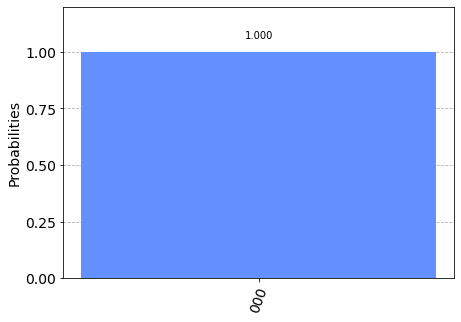

Testing for initial state [0, 1] and expected measurment state 101


┌───┐ ░ ┌───────────┐ ░ ┌─┐      
q_0: ┤ X ├─░─┤0          ├─░─┤M├──────
     └───┘ ░ │           │ ░ └╥┘┌─┐   
q_1: ──────░─┤1 addition ├─░──╫─┤M├───
           ░ │           │ ░  ║ └╥┘┌─┐
q_2: ──────░─┤2          ├─░──╫──╫─┤M├
           ░ └───────────┘ ░  ║  ║ └╥┘
c: 3/═════════════════════════╩══╩══╩═
                              0  1  2

✅ Correct prediction 🎉


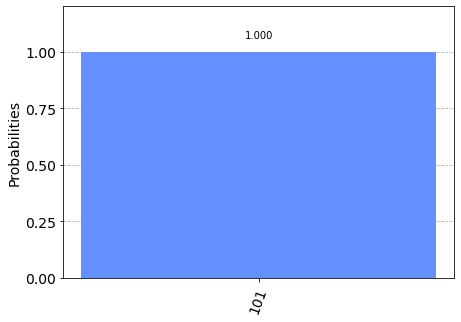

Testing for initial state [1, 0] and expected measurment state 110


░ ┌───────────┐ ░ ┌─┐      
q_0: ──────░─┤0          ├─░─┤M├──────
     ┌───┐ ░ │           │ ░ └╥┘┌─┐   
q_1: ┤ X ├─░─┤1 addition ├─░──╫─┤M├───
     └───┘ ░ │           │ ░  ║ └╥┘┌─┐
q_2: ──────░─┤2          ├─░──╫──╫─┤M├
           ░ └───────────┘ ░  ║  ║ └╥┘
c: 3/═════════════════════════╩══╩══╩═
                              0  1  2

✅ Correct prediction 🎉


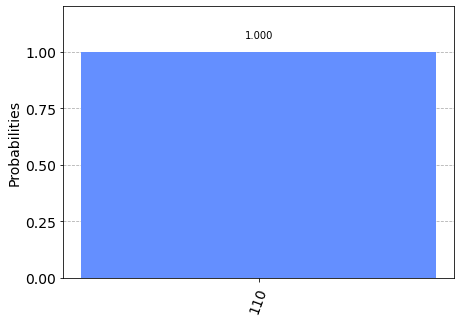

Testing for initial state [1, 1] and expected measurment state 011


┌───┐ ░ ┌───────────┐ ░ ┌─┐      
q_0: ┤ X ├─░─┤0          ├─░─┤M├──────
     ├───┤ ░ │           │ ░ └╥┘┌─┐   
q_1: ┤ X ├─░─┤1 addition ├─░──╫─┤M├───
     └───┘ ░ │           │ ░  ║ └╥┘┌─┐
q_2: ──────░─┤2          ├─░──╫──╫─┤M├
           ░ └───────────┘ ░  ║  ║ └╥┘
c: 3/═════════════════════════╩══╩══╩═
                              0  1  2

✅ Correct prediction 🎉


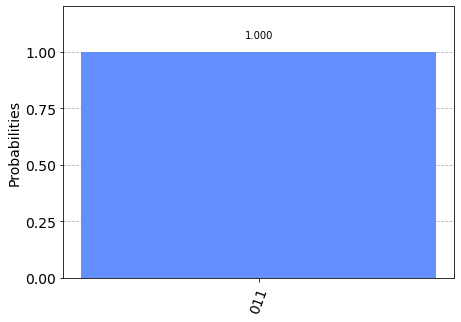

In [15]:
#creates static states to assert the matrix works correctly
state_matrix = [[0,0],
                [0,1],
                [1,0],
                [1,1]]

#note that the MSB is the "output" bit C, and the LSB is the input bit A, the middle bit the input bit B
#so we are doing A + B = C
#MSB being the leftmost bit
expected_states = [ '000',
                    '101',
                    '110',
                    '011']

for index, expected_state in enumerate(expected_states):
    print("Testing for initial state " + str(state_matrix[index]) + " and expected measurment state " + expected_state)
    circuit = generate_circuit(index)
    display(circuit.draw())
    counts, _, _ = compile_circuit_and_check(circuit, expected_states[index])
    display(plot_histogram(counts))

As we can see, our selfmade addition matrix $U_{add}$ works correctly, as proven trough the simulator.

### Carry over

A classical Full adder always has a _Carry over_ bit. This bit is to signal the overflow to the next adder:

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/48/1-bit_full-adder.svg" />

<em>Image 3: <a href="https://en.wikipedia.org/wiki/Adder_(electronics)#Full_adder">Full adder</a></em>
</center>

The _Carry over_ bit (from now on referenced as $C_{out}$) is critical to building a circuit that can add more than 1 bit wide numbers. Due to this we have to create another matrix that can fulfill the required needs. As is observable in _Image 3_, we also need an input bit that servers as $C_{in}$, to receive the signal from the previous full adder.

$$
q_0 =\ B\\
q_1 =\ A\\
q_3 =\ C_{in} \text{or}\ O\\ 
q_4 =\ C_{out}
$$

<center>

| Out/Carry In | A | B | Carry Out | Result |
|:------------:|:-:|:-:|:---------:|--------|
|       0      | 0 | 0 |     0     |   000  |
|       0      | 0 | 1 |     0     |   101  |
|       0      | 1 | 0 |     0     |   110  |
|       0      | 1 | 1 |     1     |   011  |
|       1      | 0 | 0 |     0     |   100  |
|       1      | 0 | 1 |     1     |   001  |
|       1      | 1 | 0 |     1     |   010  |
|       1      | 1 | 1 |     1     |   111  |

</center>

Again, we use the formula from above with $n = 2^4$ to create the matrix

$$
U_{add} = \Sigma_{i=0}^{16} O_{i} *\ S_{i}^T = \begin{pmatrix}
     1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
     0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
     0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
     0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
     0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
     0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
     0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
     0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
     0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
     0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
     0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
     0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
     0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
     0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
     0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
     0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 \\
        \end{pmatrix}
$$

It is immediately clear that this matrix cannot be used. The most obvious reason is because the matrix does not offer complete bijection, that is, each input is mapped exactly to one output. What we have here is a _non-injective, non-surjective_ input to output mapping.

This forces us to search for other ways of handling carry over. _What if we tried using already existing gates for it?_
When we extract the only situations that lead to the $C_{out}$ being one, we can observe that only the existance of _atleast_ two ones can lead to $C_{out} =\ 1$.

<center>

| Out/Carry In | A | B | Carry Out | Result |
|:------------:|:-:|:-:|:---------:|--------|
|       0      | 1 | 1 |     1     |   011  |
|       1      | 0 | 1 |     1     |   001  |
|       1      | 1 | 0 |     1     |   010  |
|       1      | 1 | 1 |     1     |   111  |

</center>

The _Toffoli_ gate, often also refered to as _CCNOT_ gate, is a 2 qubit controlled gate that applies a flip (_X_ gate) to the third qubit. Three of the four states can be covered using the _CCNOT_ gate. As the fourth state of $S_4 =\ \{A = 1 \wedge\ B = 1 \wedge\ C = 1\}$ is covered by the state $S_1 =\ \{A = 1 \wedge\ B = 1\}$, we will omit it for now.

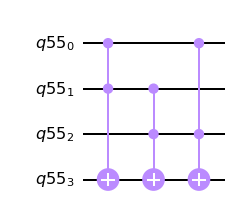

In [16]:
#4 qubits as defined on the table
sub_circuit = QuantumRegister(4)
carry_out = QuantumCircuit(sub_circuit, name="carry over")
carry_out.ccx(0,1,3)
carry_out.ccx(1,2,3)
carry_out.ccx(0,2,3)
carry_out.draw('mpl')

In [17]:
#function to generate testable circuits with the carry_over circuit
def generate_circuit(index):
    circuit = QuantumCircuit(4,4)
    if(state_matrix[index][2] == 1):
        circuit.x(0)
    if(state_matrix[index][1] == 1):
        circuit.x(1)
    if(state_matrix[index][0] == 1):
        circuit.x(2)
    circuit.barrier()
    circuit.append(carry_out, [0,1,2,3])
    circuit.unitary(addition, [0, 1, 2], label='addition')
    circuit.barrier()
    circuit.measure(range(4),range(4)) 
    return circuit



--------------------------------
Testing for initial state [0, 1, 1] and expected measurment state 1011


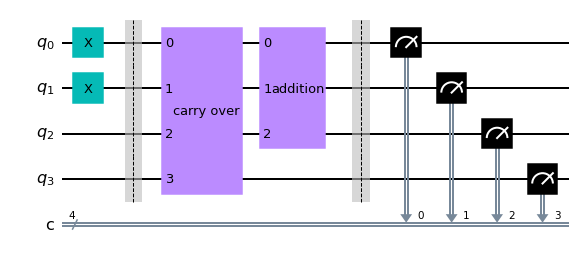

✅ Correct prediction 🎉


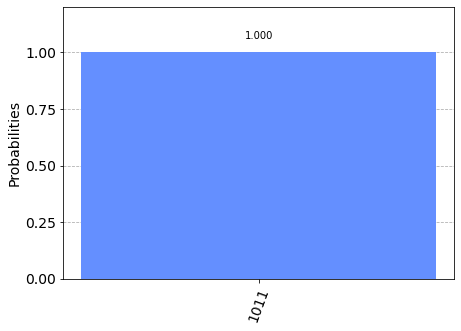

--------------------------------
Testing for initial state [1, 0, 1] and expected measurment state 1001


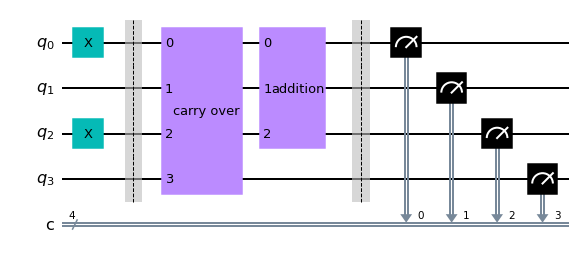

✅ Correct prediction 🎉


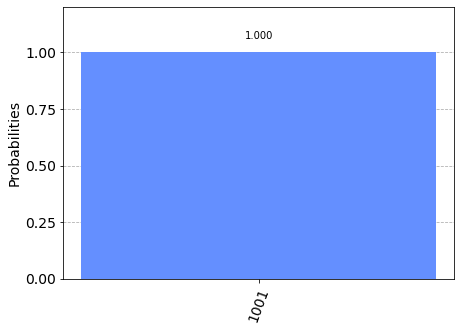

--------------------------------
Testing for initial state [1, 1, 0] and expected measurment state 1010


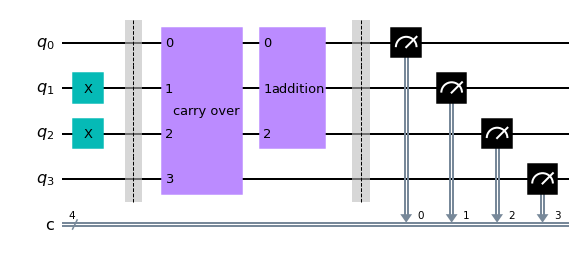

✅ Correct prediction 🎉


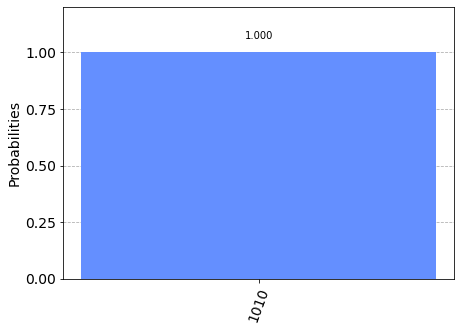

--------------------------------
Testing for initial state [1, 1, 1] and expected measurment state 1111


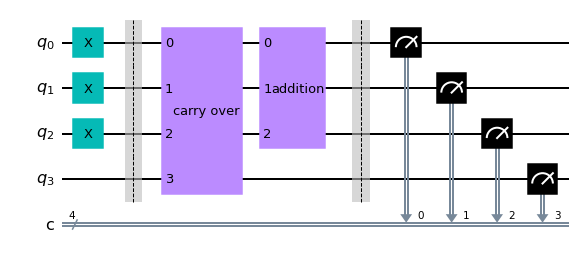

✅ Correct prediction 🎉


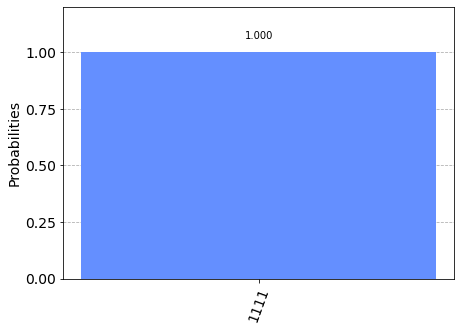

In [18]:
#we can only set the inital 3 qubits A and B (inputs) and C (carry in)
state_matrix = [[0,1,1],
                [1,0,1],
                [1,1,0],
                [1,1,1]]

#We have to check all 4 output bits to see if it holds up!
expected_states = [ '1011',
                    '1001',
                    '1010',
                    '1111']

for index, expected_state in enumerate(expected_states):
    print("--------------------------------")
    print("Testing for initial state " + str(state_matrix[index]) + " and expected measurment state " + expected_state)
    circuit = generate_circuit(index)
    display(circuit.draw('mpl'))
    counts, _, _ = compile_circuit_and_check(circuit, expected_states[index])
    display(plot_histogram(counts))

Now, lets create a silent check to see if this circuit holds true for _all_ cases that were defined in the table in a silent fashion

In [19]:
#silent fashion means no large print outs that cluster your view :)
state_matrix = [[0,0,0],
                [0,0,1],
                [0,1,0],
                [0,1,1],
                [1,0,0],
                [1,0,1],
                [1,1,0],
                [1,1,1]]

expected_states = [ '0000',
                    '0101',
                    '0110',
                    '1011', 
                    '0100', 
                    '1001',
                    '1010',
                    '1111']

for index, expected_state in enumerate(expected_states):
    print("--------------------------------")
    print("Testing for initial state " + str(state_matrix[index]) + " and expected measurment state " + expected_state)
    circuit = generate_circuit(index)
    counts, _, _ = compile_circuit_and_check(circuit, expected_states[index])
    

--------------------------------
Testing for initial state [0, 0, 0] and expected measurment state 0000
✅ Correct prediction 🎉
--------------------------------
Testing for initial state [0, 0, 1] and expected measurment state 0101
✅ Correct prediction 🎉
--------------------------------
Testing for initial state [0, 1, 0] and expected measurment state 0110
✅ Correct prediction 🎉
--------------------------------
Testing for initial state [0, 1, 1] and expected measurment state 1011
✅ Correct prediction 🎉
--------------------------------
Testing for initial state [1, 0, 0] and expected measurment state 0100
✅ Correct prediction 🎉
--------------------------------
Testing for initial state [1, 0, 1] and expected measurment state 1001
✅ Correct prediction 🎉
--------------------------------
Testing for initial state [1, 1, 0] and expected measurment state 1010
✅ Correct prediction 🎉
--------------------------------
Testing for initial state [1, 1, 1] and expected measurment state 1111
✅ Corre

As we can see, we have managed to create a full adder circuit that can add 1 bit wide numbers. Trough code we also asserted the correct functionality of the circuit.

# n qubit full adder

To create a variable length full adder, we have to know how many qubits we need beforehand. Current hardware is limited by the amount of usable qubits. This leads to caution when designing circuits - it's better to use as little as possible.
When we look back at _Image 3_, we can see that a classical _full adder_ has a $C_{in}$ as well as a $C_{out}$. Considering we already have to bring in a third qubit for the basic gate $U_{add}$, we can see how every gate after the first one can reuse $C_{out}$ as $C_{in}$. This is the same in classical circuits:

<center>
<img src="http://www.spec.gmu.edu/~pparis/classes/notes_101/img109.gif" />

<em>Image 4: <a href="http://www.spec.gmu.edu/~pparis/classes/notes_101/node112.html">2-bit adder</a></em>
</center>

With this knowledge we can deduct a function to calculate the amount of qubits needed to be able to add _n_-bit wide words

$$
3n =\ \text{qubits needed}
$$

## Parameterized Gates

To allow for a variable input for bit words $A$ and $B$ we could either rely on rebuilding the circuit with _X_ gates at the corresponding qubit, or use _parameterizable_ gates. There are a variety of different $R$ (as in rotational) gates around the three axes $X, Y$ and $Z$. 
We will, for no specific reason apart from previously using the $X$ gate, use the [$RX$ gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXGate.html). Its matrix is as follows, where as $\theta$ is the parameter

$$
\begin{split}RX(\theta) = exp(-i \frac{\theta}{2} X) =
    \begin{pmatrix}
        \cos{\frac{\theta}{2}}   & -i\sin{\frac{\theta}{2}} \\
        -i\sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}}
    \end{pmatrix}\end{split}
$$

As this is a rotation gate, we use $\pi$ to apply a rotation. As the base state for $X$ is $\ket{0}$, we have to apply $\pi$ to it to rotate it to $\ket{1}$. This can be visualized with qiskit:


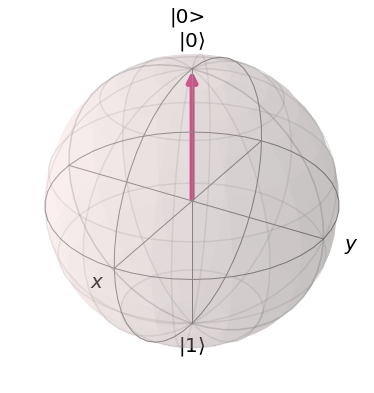

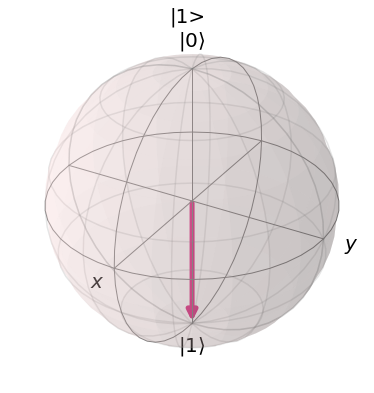

In [20]:
#states |0> and |1>
display(plot_bloch_vector([0,0,1], title="|0>"))
display(plot_bloch_vector([0,0,-1], title="|1>"))

Lets now verify this using a circuit

In [21]:
atheta = Parameter('aθ')
btheta = Parameter('bθ')
circuit = QuantumCircuit(2,2)
circuit.rx(atheta,0)
circuit.rx(btheta,1)
circuit.barrier()
circuit.measure(range(2), range(2))

states = [  [0,0],
            [0,1],
            [1,0],
            [1,1]]

expected_values = [ '00',
                    '01',
                    '10',
                    '11']

for idx, val in enumerate(states):
    print("--------------------------------")
    print("Testing for initial state " + str(val) + " and expected measurment state " + expected_values[idx])
    circuits = [circuit.bind_parameters([val[1]*np.pi, val[0]*np.pi])]
    display(circuits[-1].draw())
    compile_circuit_and_check(circuits[-1], expected_values[idx])

--------------------------------
Testing for initial state [0, 0] and expected measurment state 00


┌─────────┐ ░ ┌─┐   
q_0: ┤ Rx(0.0) ├─░─┤M├───
     ├─────────┤ ░ └╥┘┌─┐
q_1: ┤ Rx(0.0) ├─░──╫─┤M├
     └─────────┘ ░  ║ └╥┘
c: 2/═══════════════╩══╩═
                    0  1

✅ Correct prediction 🎉
--------------------------------
Testing for initial state [0, 1] and expected measurment state 01


┌───────┐  ░ ┌─┐   
q_0: ─┤ Rx(π) ├──░─┤M├───
     ┌┴───────┴┐ ░ └╥┘┌─┐
q_1: ┤ Rx(0.0) ├─░──╫─┤M├
     └─────────┘ ░  ║ └╥┘
c: 2/═══════════════╩══╩═
                    0  1

✅ Correct prediction 🎉
--------------------------------
Testing for initial state [1, 0] and expected measurment state 10


┌─────────┐ ░ ┌─┐   
q_0: ┤ Rx(0.0) ├─░─┤M├───
     └┬───────┬┘ ░ └╥┘┌─┐
q_1: ─┤ Rx(π) ├──░──╫─┤M├
      └───────┘  ░  ║ └╥┘
c: 2/═══════════════╩══╩═
                    0  1

✅ Correct prediction 🎉
--------------------------------
Testing for initial state [1, 1] and expected measurment state 11


┌───────┐ ░ ┌─┐   
q_0: ┤ Rx(π) ├─░─┤M├───
     ├───────┤ ░ └╥┘┌─┐
q_1: ┤ Rx(π) ├─░──╫─┤M├
     └───────┘ ░  ║ └╥┘
c: 2/═════════════╩══╩═
                  0  1

✅ Correct prediction 🎉


With this assertion, we can now start the final step of collecting our knowledge and building a generator for a $n$-bit full adder using quantum gates

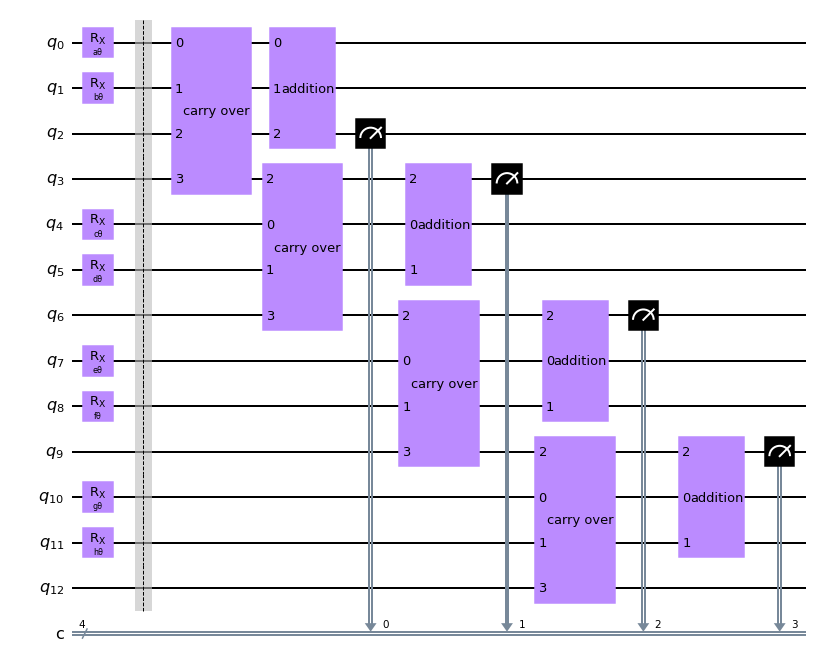

In [24]:
def create_parameters(nparameters):
    if nparameters > 123-97:
        raise Exception('The generator is limited to ' + str(123-97-1) + ' bits!')
    else:
        params = []
        for i in range(97, 97+nparameters):
            params.append(Parameter(chr(i) + 'θ'))
    return params

def get_carry_over_circuit():
    sub_circuit = QuantumRegister(4)
    carry_out = QuantumCircuit(sub_circuit, name="carry over")
    carry_out.ccx(0,1,3)
    carry_out.ccx(1,2,3)
    carry_out.ccx(0,2,3)
    return carry_out

def get_adder_circuit():
    return qi.Operator([[1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1]])


def create_full_adder(nbits):
    if nbits < 1:
        raise Exception('You can\'t add less than 1 bit together!')
    n = 3 * nbits + 1
    if n < 4: n = 4
    circuit = QuantumCircuit(n,nbits)
    parameters = create_parameters(2*nbits)
    iterparam = parameters.copy()
    circuit.rx(iterparam[0],0)
    circuit.rx(iterparam[1],1)
    del iterparam[0:2]
    iterable_parameters = iter(iterparam)
    for i in range(4,n):
        if i%3 == 0:
            continue
        else:
            circuit.rx(next(iterable_parameters),i)
    circuit.barrier()
    #start the circuitry

    for i in range(nbits):
        if i == 0:
            circuit.append(get_carry_over_circuit(), [0, 1, 2, 3])
            circuit.unitary(get_adder_circuit(), [0, 1, 2], label='addition')
            circuit.measure(2,0)
        else:
            circuit.append(get_carry_over_circuit(), [i*3+1, i*3+2, i*3, i*3+3])
            circuit.unitary(get_adder_circuit(), [i*3+1, i*3+2, i*3], label='addition')
            circuit.measure(i*3,i)

    return circuit

#drawin a max sized adder. max size is limited due to the alphabet not having more letters :)
#watch out! using anything over 4 qubits on a local simulator will lead to exponentially large waiting times or even crash your python kernel
create_full_adder(4).draw('mpl')

Now let's automate testing and make it go trough _every single possible input combination_ for $n$-bit wide words and check its output to assert that it's working as expected.

In [23]:
# qubits to simulate and test:
n = 3


def compile_circuit_and_test(circuit, expected_value):
    result = False
    simulator = QasmSimulator()
    compiled_circuit = transpile(circuit, simulator)
    job = simulator.run(compiled_circuit, shots=3000)
    result = job.result()
    counts = result.get_counts(circuit)
    keys = counts.keys()
    if len(keys) == 1 and expected_value == list(keys)[0]:
        result = True
    return result, list(keys)[0]

def turn_binary_strings_to_parameters(n, A, B):
    Aiter = iter(A.replace('0b','')[::-1])
    Biter = iter(B.replace('0b','')[::-1])
    result = bin(int(A,2)+int(B,2)).replace('0b','')
    params = np.zeros(n*2)
    for i in range(0,n*2,2):
        params[i] = int(next(Aiter, 0))*np.pi
        params[i+1] = int(next(Biter, 0))*np.pi
    return params, result

def format_binary_to_length(n, binary):
    while len(binary) > n:
        binary = binary[1:]
    while len(binary) < n:
        binary = '0' + binary
    return binary

results = []
circuit = create_full_adder(n)
display(circuit.draw())

for i in range(2**n):
    A = bin(i).replace('0b','')
    for j in range(2**n):
        B = bin(j).replace('0b','')
        Aiter = iter(A[::-1])
        Biter = iter(B[::-1])
        A = format_binary_to_length(n, A)
        B = format_binary_to_length(n, B)
        params, C = turn_binary_strings_to_parameters(n, A, B)
        C = format_binary_to_length(n, C)
        qc = circuit.bind_parameters(params)
        result, Ccalculated = compile_circuit_and_test(qc, C)
    
        results.append([A,B,C,Ccalculated, '✅' if result else '❌'])


from IPython.display import display, Markdown, Latex
display(Markdown('|Ain | Bin | Cexpected | Ccalculated | Result |\n'+'|:---:|:---:|:-----:|:------:|--------|\n'+''.join(['|'+val[0]+'|'+val[1]+'|'+val[2]+'|'+val[3]+'|'+val[4]+'|\n' for val in results])))

┌────────┐ ░ ┌─────────────┐ ┌───────────┐                      »
q_0: ┤ Rx(aθ) ├─░─┤0            ├─┤0          ├──────────────────────»
     ├────────┤ ░ │             │ │           │                      »
q_1: ┤ Rx(bθ) ├─░─┤1            ├─┤1 addition ├──────────────────────»
     └────────┘ ░ │  carry over │ │           │ ┌─┐                  »
q_2: ───────────░─┤2            ├─┤2          ├─┤M├──────────────────»
                ░ │             │┌┴───────────┴┐└╥┘ ┌───────────┐ ┌─┐»
q_3: ───────────░─┤3            ├┤2            ├─╫──┤2          ├─┤M├»
     ┌────────┐ ░ └─────────────┘│             │ ║  │           │ └╥┘»
q_4: ┤ Rx(cθ) ├─░────────────────┤0            ├─╫──┤0 addition ├──╫─»
     ├────────┤ ░                │  carry over │ ║  │           │  ║ »
q_5: ┤ Rx(dθ) ├─░────────────────┤1            ├─╫──┤1          ├──╫─»
     └────────┘ ░                │             │ ║ ┌┴───────────┴┐ ║ »
q_6: ───────────░────────────────┤3            ├─╫─┤2            ├─╫─»
     ┌────────┐ ░                └─────────────┘ ║ │             │ ║ »
q_7: ┤ Rx(eθ) ├─░────────────────────────────────╫─┤0            ├─╫─»
     ├────────┤ ░                                ║ │  carry over │ ║ »
q_8: ┤ Rx(fθ) ├─░────────────────────────────────╫─┤1            ├─╫─»
     └────────┘ ░                                ║ │             │ ║ »
q_9: ───────────░────────────────────────────────╫─┤3            ├─╫─»
                ░                                ║ └─────────────┘ ║ »
c: 3/════════════════════════════════════════════╩═════════════════╩═»
                                                 0                 1 »
«                     
«q_0: ────────────────
«                     
«q_1: ────────────────
«                     
«q_2: ────────────────
«                     
«q_3: ────────────────
«                     
«q_4: ────────────────
«                     
«q_5: ────────────────
«     ┌───────────┐┌─┐
«q_6: ┤2          ├┤M├
«     │           │└╥┘
«q_7: ┤0 addition ├─╫─
«     │           │ ║ 
«q_8: ┤1          ├─╫─
«     └───────────┘ ║ 
«q_9: ──────────────╫─
«                   ║ 
«c: 3/══════════════╩═
«                   2

|Ain | Bin | Cexpected | Ccalculated | Result |
|:---:|:---:|:-----:|:------:|--------|
|000|000|000|000|✅|
|000|001|001|001|✅|
|000|010|010|010|✅|
|000|011|011|011|✅|
|000|100|100|100|✅|
|000|101|101|101|✅|
|000|110|110|110|✅|
|000|111|111|111|✅|
|001|000|001|001|✅|
|001|001|010|010|✅|
|001|010|011|011|✅|
|001|011|100|100|✅|
|001|100|101|101|✅|
|001|101|110|110|✅|
|001|110|111|111|✅|
|001|111|000|000|✅|
|010|000|010|010|✅|
|010|001|011|011|✅|
|010|010|100|100|✅|
|010|011|101|101|✅|
|010|100|110|110|✅|
|010|101|111|111|✅|
|010|110|000|000|✅|
|010|111|001|001|✅|
|011|000|011|011|✅|
|011|001|100|100|✅|
|011|010|101|101|✅|
|011|011|110|110|✅|
|011|100|111|111|✅|
|011|101|000|000|✅|
|011|110|001|001|✅|
|011|111|010|010|✅|
|100|000|100|100|✅|
|100|001|101|101|✅|
|100|010|110|110|✅|
|100|011|111|111|✅|
|100|100|000|000|✅|
|100|101|001|001|✅|
|100|110|010|010|✅|
|100|111|011|011|✅|
|101|000|101|101|✅|
|101|001|110|110|✅|
|101|010|111|111|✅|
|101|011|000|000|✅|
|101|100|001|001|✅|
|101|101|010|010|✅|
|101|110|011|011|✅|
|101|111|100|100|✅|
|110|000|110|110|✅|
|110|001|111|111|✅|
|110|010|000|000|✅|
|110|011|001|001|✅|
|110|100|010|010|✅|
|110|101|011|011|✅|
|110|110|100|100|✅|
|110|111|101|101|✅|
|111|000|111|111|✅|
|111|001|000|000|✅|
|111|010|001|001|✅|
|111|011|010|010|✅|
|111|100|011|011|✅|
|111|101|100|100|✅|
|111|110|101|101|✅|
|111|111|110|110|✅|
